In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
import numpy as np
Skin_data = np.load('SFA_Filter_S.npy')
NonSkin_data=np.load('SFA_Filter_NS.npy')

In [3]:
input_data=[]
for i in range(2):
    if i == 0:
        for j in range(len(NonSkin_data)):
            input_data.append(NonSkin_data[j])
    else :
        for j in range(len(Skin_data)):
            input_data.append(Skin_data[j])

In [4]:
label=[]
for i in range(len(NonSkin_data)+len(Skin_data)):
    if i>len(NonSkin_data):
        label.append(0)
    else:
        label.append(1)

In [5]:
label=np.array(label)
input_data=np.array(input_data)

In [6]:
input_data= (input_data*(1/256)-0.5)/0.5

In [7]:
input_data=torch.FloatTensor(input_data)
label=torch.LongTensor(label)

In [8]:
input_data.shape

torch.Size([1753024, 9, 5])

In [29]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
dataset = TensorDataset(input_data,label)

In [38]:
trainset,valset=torch.utils.data.random_split(dataset,[1403024,350000])
trainset,testset=torch.utils.data.random_split(trainset,[1053024,350000])

partition={'train':trainset,'val':valset,'test':testset}

# 2-dim M

In [6]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
class GCN(nn.Module):
    def __init__(self):
        super(GCN,self).__init__()
        A = [[1, 1, 0, 1, 1, 0, 0, 0, 0],
             [1, 1, 1, 1, 1, 1, 0, 0, 0],
             [0 ,1, 1, 0, 1, 1, 0, 0, 0],
             [1, 1, 0, 1, 1, 0, 1, 1, 0],
             [1, 1, 1, 1, 1, 1, 1, 1, 1],
             [0, 1, 1, 0, 1, 1, 0, 1, 1],
             [0, 0, 0, 1, 1, 0, 1, 1, 0],
             [0, 0, 0, 1, 1, 1, 1, 1, 1],
             [0, 0, 0, 0, 1, 1, 0, 1, 1]]
        adj=torch.FloatTensor(A)
        adj=adj.cuda()
        self.adj=adj
        self.W= nn.Parameter(torch.detach(torch.rand(5,10)).requires_grad_(True))
        self.W1= nn.Parameter(torch.detach(torch.rand(10,20)).requires_grad_(True))#hid_dim이라 생각하면 편함
        self.act = nn.Sigmoid()
        self.Linear=nn.Linear(180,9)
        self.Linear1=nn.Linear(9,2)
#ReLU 쓰니까 out 이 2번째에서 다 0값이 나옴.
        
    def forward(self,x):
        out = torch.matmul(x,self.W)
        out = torch.matmul(self.adj,out)
        out = torch.matmul(out,self.W1)
        out = torch.matmul(self.adj,out)
        out = out.view(-1,180)
        out = self.Linear(out)
        out = self.act(out)
        out = self.Linear1(out)
        #out=F.softmax(out,dim=1)
        
        return out

In [35]:
def train(net,partition,optimizer,creiterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=4096,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [37]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=4096, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [46]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=4096, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [3]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [208]:
net=GCN()
net.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
train_losses=[]
val_losses=[]
train_accs=[]
val_accs=[]
for epoch in range(20):
    ts=time.time()
    net, train_loss,train_acc=train(net, partition, optimizer, criterion)
    val_loss, val_acc = validate(net, partition, criterion)
    te=time.time()
    print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))
    
    train_loss=round(train_loss,2)#리스트에 넣기 위해 3번째 자릿수 반올림
    val_loss=round(val_loss,2)
    train_acc=round(train_acc,2)
    val_acc=round(val_acc,2)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)    
    
    
test_acc = test1(net,partition,criterion)
test_acc=round(test_acc,2)
result = {}
result['train_losses'] = train_losses
result['val_losses'] = val_losses
result['train_accs'] = train_accs
result['val_accs'] = val_accs
result['train_acc'] = train_acc
result['val_acc'] = val_acc
result['test_acc'] = test_acc


  1%|          | 2/258 [00:00<00:22, 11.19it/s]

time : 12.43, train_loss : 0.36, train_acc : 84.59,val_acc : 91.86,val_loss : 0.27


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.42, train_loss : 0.22, train_acc : 92.57,val_acc : 92.96,val_loss : 0.21


  1%|          | 2/258 [00:00<00:17, 14.61it/s]

time : 12.34, train_loss : 0.20, train_acc : 93.13,val_acc : 93.47,val_loss : 0.19


  1%|          | 2/258 [00:00<00:14, 17.39it/s]

time : 12.34, train_loss : 0.19, train_acc : 93.31,val_acc : 93.38,val_loss : 0.18


  1%|          | 2/258 [00:00<00:17, 14.47it/s]

time : 12.57, train_loss : 0.18, train_acc : 93.50,val_acc : 93.76,val_loss : 0.18


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.85, train_loss : 0.18, train_acc : 93.65,val_acc : 93.10,val_loss : 0.18


  0%|          | 1/258 [00:00<00:47,  5.42it/s]

time : 12.88, train_loss : 0.17, train_acc : 93.84,val_acc : 94.00,val_loss : 0.16


  0%|          | 1/258 [00:00<00:37,  6.90it/s]

time : 12.69, train_loss : 0.16, train_acc : 93.98,val_acc : 93.63,val_loss : 0.16


  1%|          | 2/258 [00:00<00:13, 18.63it/s]

time : 12.50, train_loss : 0.15, train_acc : 94.55,val_acc : 94.70,val_loss : 0.16


  1%|          | 2/258 [00:00<00:14, 17.88it/s]

time : 12.21, train_loss : 0.14, train_acc : 94.86,val_acc : 94.82,val_loss : 0.14


  0%|          | 0/258 [00:00<?, ?it/s]

time : 12.53, train_loss : 0.14, train_acc : 94.98,val_acc : 95.01,val_loss : 0.14


  0%|          | 1/258 [00:00<00:46,  5.50it/s]

time : 12.53, train_loss : 0.13, train_acc : 95.39,val_acc : 95.79,val_loss : 0.13


  1%|          | 2/258 [00:00<00:14, 17.81it/s]

time : 12.62, train_loss : 0.13, train_acc : 95.72,val_acc : 95.72,val_loss : 0.14


  1%|          | 2/258 [00:00<00:17, 15.01it/s]

time : 12.36, train_loss : 0.12, train_acc : 95.81,val_acc : 95.48,val_loss : 0.13


  1%|          | 2/258 [00:00<00:13, 18.49it/s]

time : 12.19, train_loss : 0.13, train_acc : 95.73,val_acc : 95.95,val_loss : 0.12


  0%|          | 1/258 [00:00<00:39,  6.45it/s]

time : 12.28, train_loss : 0.12, train_acc : 95.87,val_acc : 95.81,val_loss : 0.12


  1%|          | 2/258 [00:00<00:14, 17.22it/s]

time : 12.67, train_loss : 0.12, train_acc : 95.92,val_acc : 95.37,val_loss : 0.15


  1%|          | 2/258 [00:00<00:17, 14.76it/s]

time : 12.22, train_loss : 0.12, train_acc : 95.93,val_acc : 94.99,val_loss : 0.14


  0%|          | 1/258 [00:00<00:48,  5.32it/s]

time : 12.69, train_loss : 0.12, train_acc : 95.94,val_acc : 96.26,val_loss : 0.12


  0%|          | 0/86 [00:00<?, ?it/s]

time : 12.80, train_loss : 0.12, train_acc : 96.01,val_acc : 96.17,val_loss : 0.11


100%|██████████| 86/86 [00:01<00:00, 43.84it/s]


# model Save

In [209]:
torch.save(net,'testmodel1.pt') #저장됨

#torch.save(net.state_dic(),'testmodel_state_dict.pt') #저장안됨
torch.save({
    'model' : net.state_dict(),
    'optimizer' : optimizer.state_dict()
},"all1.tar")#여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch,loss 값 등 일반 scalar값 저장

# model Load

https://justkode.kr/deep-learning/pytorch-save reference

In [7]:
model = torch.load('testmodel1.pt')
"""
model = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
"""
model.cuda()

GCN(
  (act): Sigmoid()
  (Linear): Linear(in_features=180, out_features=9, bias=True)
  (Linear1): Linear(in_features=9, out_features=2, bias=True)
)

In [8]:
model.eval()

GCN(
  (act): Sigmoid()
  (Linear): Linear(in_features=180, out_features=9, bias=True)
  (Linear1): Linear(in_features=9, out_features=2, bias=True)
)

In [9]:
import cv2

(180, 180, 3)

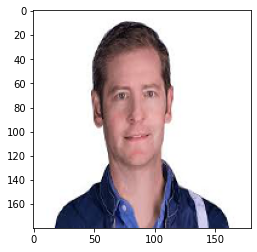

In [216]:
img=cv2.imread("testimage1.jpg")
img=cv2.resize(img,(180,180), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

In [217]:
def YCbCrTransform(x):
    #================= exponancial function ==================#
    exponancial=[[65.738, 129.057, 25.064],
                 [-37.945, -74.494, 112.439],
                 [112.439, -94.154, -18.285]]
    exponancial=np.matrix(exponancial)
    exponancial=(1/256)*exponancial
    
    A=[[16],[128],[128]]
    A=np.matrix(A)
    #=========================================================#
    x=np.matrix(x)
    x=np.transpose(x)
    Answer=A+exponancial*x
    Answer=np.array(Answer)
    Answer=Answer.tolist()
    Cb=Answer[1][0]
    Cr=Answer[2][0]
    
    return Cb,Cr
def Make_redemention(x):
    before_result=[]
    for i in range(x.shape[0]):    #x.shape[0]
        before_result1=[]
        for j in range(x.shape[1]):
            before_result2=[]
            for k in range(x.shape[2]):
                before_result3=[]
                before=x[i][j][k]
                Cb,Cr=YCbCrTransform(before)
                before_result3.append(before[0])
                before_result3.append(before[1])
                before_result3.append(before[2])
                before_result3.append(Cb)
                before_result3.append(Cr)
                before_result2.append(before_result3)
            before_result1.append(before_result2)
        before_result.append(before_result1)
    return before_result
def reshape_demension(x):
    make_result=[]
    for i in range(x.shape[0]):
        make_result1=[]
        for j in range(x.shape[1]):
            for k in range(x.shape[2]):
                make_result1.append(x[i][j][k])
        make_result.append(make_result1)
    return make_result

In [218]:
test_result=[]
for i in range(len(img)-3):
    for k in range(len(img[0])-3):
        make_data=img[i:i+3,k:k+3]
        test_result.append(make_data)

In [219]:
test_result=np.array(test_result)

In [220]:
test_result.shape

(31329, 3, 3, 3)

In [221]:
AAA=Make_redemention(test_result)
AAA=np.array(AAA,dtype=np.uint8)
AAA1=reshape_demension(AAA)
AAA1=np.array(AAA1)
AAA1= (AAA1*(1/256)-0.5)/0.5
test_input=torch.FloatTensor(AAA1)

In [222]:
test_input.shape
result_data=[]
for i in range(len(test_input)):
    in_test_result=test_input[i]
    in_test_result=in_test_result.cuda()
    out_test=model(in_test_result)
    _, predicted = torch.max(out_test.data, 1)
    #print(predicted)
    result_data.append(predicted)    

In [223]:
tototo=[]
for i in range(len(result_data)):
    if result_data[i][0]==0:
        tototo.append(0)
    else:
        tototo.append(1)
        #print(1)

In [224]:
tototo=np.array(tototo)

In [225]:
tototo.shape

(31329,)

In [226]:
result_img=[]
for i in range(len(img)-3):
    result_img1=[]
    for j in range(len(img[0])-3):
        if tototo[j+i*(len(img[0])-3)] ==0:
            result_img1.append([0,0,0])
        else:
            result_img1.append([255,255,255])
    result_img.append(result_img1)
    result_img1=[]

In [227]:
result_img=np.array(result_img,dtype=np.uint8)

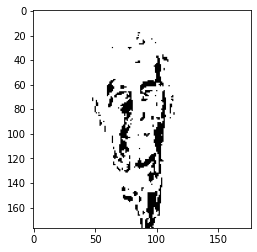

In [228]:
plt.imshow(result_img)
plt.show()